# Word2Vec

## Positive & Negative Corpus

In [ ]:
corpus = '''
elma suyu
portakal suyu
vişne suyu
kayısı suyu

facebook şirketi
google şirketi
microsoft şirketi
mcdonalds şirketi
yahoo şirketi
mcdonalds burger
burgerking burger
kofteciyusuf burger
'''

corpus_negative = '''
elma şirketi
portakal burger
vişne burger
kayısı şirketi

facebook suyu
mcdonalds suyu
mcdonalds suyu
kofteciyusuf suyu
microsoft burger
yahoo suyu
'''

## Manipulate the Corpus

In [ ]:
import pandas as pd

id2tok = dict(enumerate(corpus.lower().split()))
tok2id = {token: id for id, token in id2tok.items()}

lines = corpus.strip().split('\n')
lines_negative = corpus_negative.strip().split('\n')
normal_data = {'input1': [], 'input2': [], 'output': []}
reverse_data = {'input1': [], 'input2': [], 'output': []}

for line in lines:
  tokens = line.split()
  if len(tokens) == 2:
    normal_data['input1'].append(tokens[0])
    normal_data['input2'].append(tokens[1])
    normal_data['output'].append(1)

    reverse_data['input1'].append(tokens[1])
    reverse_data['input2'].append(tokens[0])
    reverse_data['output'].append(1)

for line in lines_negative:
  tokens = line.split()
  if len(tokens) == 2:
    normal_data['input1'].append(tokens[0])
    normal_data['input2'].append(tokens[1])
    normal_data['output'].append(0)

    reverse_data['input1'].append(tokens[1])
    reverse_data['input2'].append(tokens[0])
    reverse_data['output'].append(0)

df_normal = pd.DataFrame(normal_data)
df_normal

,input1,input2,output
0,elma,suyu,1
1,portakal,suyu,1
2,vişne,suyu,1
3,kayısı,suyu,1
4,facebook,şirketi,1
5,google,şirketi,1
6,microsoft,şirketi,1
7,mcdonalds,şirketi,1
8,yahoo,şirketi,1
9,mcdonalds,burger,1


In [ ]:
df_reverse = pd.DataFrame(reverse_data)
df_reverse

,input1,input2,output
0,suyu,elma,1
1,suyu,portakal,1
2,suyu,vişne,1
3,suyu,kayısı,1
4,şirketi,facebook,1
5,şirketi,google,1
6,şirketi,microsoft,1
7,şirketi,mcdonalds,1
8,şirketi,yahoo,1
9,burger,mcdonalds,1


## Dataset & Dataloader Creation

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np


class data_set(Dataset):
  def __init__(self, data):
    self.X = np.vectorize(tok2id.get)(data[:,:-1])
    self.y = data[:,-1]
  def __len__(self):
    return len(self.X)
  def __getitem__(self, index):
    return self.X[index], self.y[index]

dataset = data_set(df_normal.append(df_reverse).values)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

<ipython-input-5-2d829a234e35>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = data_set(df_normal.append(df_reverse).values)


## Wor2Vec Model

In [ ]:
class Word2Vec2(nn.Module):
  def __init__(self, vocab_size, embedding_size):
    super().__init__()
    self.embedding1 = nn.Embedding(vocab_size, embedding_size)
    self.embedding2 = nn.Embedding(vocab_size, embedding_size)

  def forward(self, X_batch):
    U = self.embedding1(X_batch[:,0])
    V = self.embedding2(X_batch[:,1])

    output = torch.sigmoid(torch.sum(torch.mul(U, V), 1))
    return output

## Training

100%|██████████| 1200/1200 [00:15<00:00, 76.91it/s] 


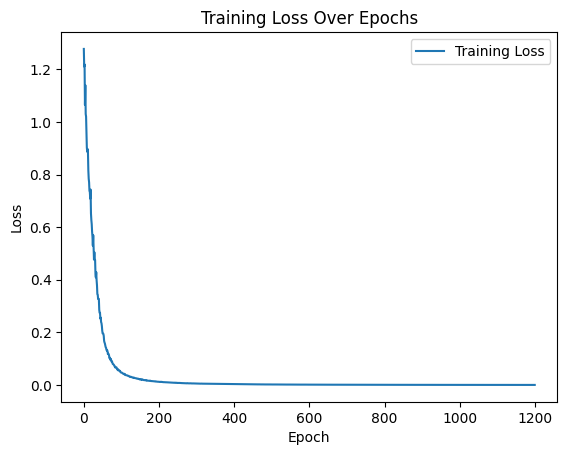

In [ ]:
from itertools import chain
from collections import Counter
import matplotlib.pyplot as plt

vocab_size = dataset.X.size
embed_size = 16

model = Word2Vec2(vocab_size, embed_size)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

LR = 3e-3
EPOCHS = 1200
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

from tqdm import tqdm # For progress bars
from IPython import display

running_loss = []
for epoch in tqdm(range(EPOCHS)):
  epoch_loss = 0
  for i, (batch_X, batch_y) in enumerate(dataloader):
    optimizer.zero_grad()

    X_batch = batch_X.type(torch.int).to(device)
    y_batch = batch_y.type(torch.float32).to(device)
    y_pred = model(X_batch)

    loss = loss_fn(y_pred, y_batch)
    epoch_loss += loss.item()
    loss.backward()

    optimizer.step()

  epoch_loss /= len(dataloader)
  running_loss.append(epoch_loss)

  print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}')
  display.clear_output(wait=True)

plt.plot(running_loss, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Test

In [ ]:
test_data = [['elma', 'suyu', 1], ['mcdonalds', 'suyu', 0], ['microsoft', 'şirketi', 1], ['burger', 'microsoft', 0]]

data_dict = {'word1': [], 'word1id': [], 'word2': [], 'word2id': [], 'result': []}

for data in test_data:
    data_dict['word1'].append(data[0])
    data_dict['word1id'].append(tok2id[data[0]])
    data_dict['word2'].append(data[1])
    data_dict['word2id'].append(tok2id[data[1]])
    data_dict['result'].append(data[2])

df = pd.DataFrame(data_dict)

In [ ]:
model.eval()

for index, row in df.iterrows():
  word1 = row['word1']
  word2 = row['word2']
  result = row['result']

  with torch.no_grad():
    single_example = torch.tensor([[row['word1id'], row['word2id']]])
    X_batch = single_example.type(torch.int).to(device)
    y_pred = model(X_batch)
    y_pred_binary = (y_pred > 0.5).int()
    df.at[index, 'pred'] = y_pred_binary[0].item()

df

,word1,word1id,word2,word2id,result,pred
0,elma,0,suyu,7,1,1.0
1,mcdonalds,18,suyu,7,0,0.0
2,microsoft,12,şirketi,17,1,1.0
3,burger,23,microsoft,12,0,0.0
